# Minimal Evaluation Demo 

In [1]:
import numpy as np
from utils.equirectangular_render import *
from utils.eval_depth import *
import glob

ply_path = f'/home/jaxa/takama/github/SDF360/SDF360/exp/barbershop-egocentric/meshes/00200000.ply'
camera_path = sorted(glob.glob('/home/jaxa/shintaro/datasets/Blender360/barbershop/Egocentric/cameras/*.json'))[0]
gt_depth_path = sorted(glob.glob('/home/jaxa/shintaro/datasets/Blender360/barbershop/Egocentric/depths/*.exr'))[0]
depth_map, normal_map = equirectangular_renderer_from_mesh(ply_path, camera_path, width=1600, height=800)
depth_map_gt = np.array(read_exr_depth(gt_depth_path)).astype(np.float32)
depth_metrics = calculate_metrics(depth_map, depth_map_gt, depth_max_value=8.0)
print(depth_metrics)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
{'RMSE': 0.3180845193985749, 'MAE': 0.0556211305111213, 'RMSE_scale_invariant': 0.8884771177201295, 'Percentage_within_threshold_1.25': 0.9873894180531012, 'MSE': 0.10117776148102238, 'RMSE_log': 0.8902426313310557, 'Abs_relative_difference': 0.024626832640050927, 'Squared_relative_difference': 0.027504740569613773}


# Visualize Rendered RGB, Depth, Normal from Mesh

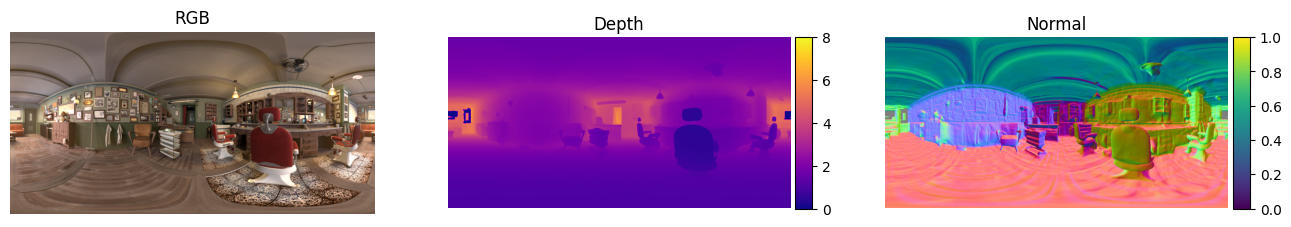

In [2]:
from PIL import Image
from utils.visualize import visualize_rgb_depth_normal
gt_rgb_path = sorted(glob.glob('/home/jaxa/shintaro/datasets/Blender360/barbershop/Egocentric/images/*.png'))[0]
rgb = np.array(Image.open(gt_rgb_path))
visualize_rgb_depth_normal(rgb, depth_map, normal_map, visualize_depth_max=8.0)